In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# import hyperas
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from tensorflow.keras.preprocessing import timeseries_dataset_from_array


import tensorflow as tf


# from hyperas import optim
# from hyperas.distributions import choice, uniform
# from hyperopt import STATUS_OK

In [2]:
df = pd.read_csv("model_data.csv")
df.drop(["Date", "Unnamed: 0"], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27140 entries, 0 to 27139
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              27140 non-null  float64
 1   dewp              27140 non-null  float64
 2   slp               27140 non-null  float64
 3   visib             27140 non-null  float64
 4   wdsp              27140 non-null  float64
 5   max               27140 non-null  float64
 6   min               27140 non-null  float64
 7   fog               27140 non-null  float64
 8   rain_drizzle      27140 non-null  float64
 9   snow_ice_pellets  27140 non-null  float64
 10  hail              27140 non-null  float64
 11  thunder           27140 non-null  float64
 12  year sin          27140 non-null  float64
 13  year cos          27140 non-null  float64
dtypes: float64(14)
memory usage: 2.9 MB


In [3]:
df.head()

,temp,dewp,slp,visib,wdsp,max,min,fog,rain_drizzle,snow_ice_pellets,hail,thunder,year sin,year cos
0,52.9,42.2,1023.1,11.2,5.8,65.3,42.4,0.0,0.0,0.0,0.0,0.0,-0.024232,-0.999706
1,61.3,52.9,1021.9,11.9,11.4,70.3,53.4,0.0,0.0,0.0,0.0,0.0,-0.041425,-0.999142
2,65.2,60.3,1019.5,10.9,7.4,75.4,58.3,0.0,0.0,0.0,0.0,0.0,-0.058606,-0.998281
3,66.7,63.3,1016.5,9.0,13.1,74.3,63.3,0.0,1.0,0.0,0.0,0.0,-0.075770,-0.997125
4,63.1,53.1,1004.4,9.8,10.3,74.3,54.3,0.0,1.0,0.0,0.0,1.0,-0.092911,-0.995674


In [4]:
# Train, Validation, Test Split
train_df = df[0:int(len(df)*.7)]
val_df = df[int(len(df)*.7):int(len(df)*.9)]
test_df = df[int(len(df)*.9):]


In [5]:
scaler = StandardScaler()
scaler.fit(train_df)


StandardScaler()

In [6]:
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [7]:
# Various window parameters
input_width = 24
label_width = 1
shift = 1
label_columns = ["temp"]

In [9]:
column_indeces = {name: i for i, name in enumerate(train_df.columns)}
if label_columns is not None:
    label_column_indeces = {name: i for i, name in enumerate(label_columns)}

window_size = input_width + shift

input_slice = slice(0, input_width)
input_indeces = np.arange(window_size)[input_slice]

label_start = window_size - label_width
label_slice = slice(label_start, None)
label_indeces =  np.arange(window_size)[label_slice]

array([24])

In [10]:
def split_window(features):
    inputs = features[:, input_slice, :]
    labels = features[:, label_slice, :]
    if label_columns:
        labels = tf.stack([labels[:, :, column_indeces[name]] for name in label_columns], axis=1)

    inputs.set_shape([None, input_width, None])
    labels.set_shape([None, label_width, None])

    return inputs, labels

In [11]:
# Examples for testing
example_window = tf.stack([np.array(train_scaled[:window_size]),
                        np.array(train_scaled[100:100+window_size]),
                        np.array(train_scaled[200:200+window_size])])
example_inputs, example_labels = split_window(example_window)


In [12]:
example_labels.shape

TensorShape([3, 1, 1])

In [13]:
def make_dataset(data):
    data = np.array(data, dtype=np.float32)
    dset = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )

    dset = dset.map(split_window)
    return dset

In [23]:
inputs, labels = example
inputs.shape

TensorShape([32, 24, 14])

In [14]:
def make_plot(example, model=None, plot_col="temp", max_subplots=3):
    inputs, labels = example
    plt.figure(figsize=(12, 8))
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f"{plot_col}")
        plt.plot(input_indeces,
         inputs[n, :, column_indeces[plot_col]],
         label="Inputs",
         marker=".",
         zorder=10)

        if label_columns:
            label_col_index = label_column_indeces.get(plot_col, None)
        else:
            label_col_index = column_indeces[plot_col]

        if label_col_index is None:
            continue

        plt.scatter(label_indeces, labels[n, :, label_col_index], edgecolors="k", label="Labels", c="#2ca02c", s=64)

        if model:
            predictions = model(inputs)
            plt.scatter(label_indeces, predictions[n:, :, label_col_index],
            marker="X", edgecolors="k", label="Predictions", c="ff7f0e", s=64)
        
        if n==0:
            plt.legend()
        
        plt.xlabel("Days")


In [15]:
def compile_fit(model, train, val, patience=2, max_epochs=20):
    e_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, mode="min")

    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(train, epochs=max_epochs, validation_data = val, callbacks=[e_stop])
    return history

In [16]:
# Simplest model for testing
linear = Sequential([
    Dense(units=1)
])

In [17]:
dense_model = Sequential()
dense_model.add(tf.keras.layers.Flatten())
dense_model.add(Dense(units=64, activation="relu"))
dense_model.add(Dense(units=64, activation="relu"))
dense_model.add(Dense(units=1))
dense_model.add(tf.keras.layers.Reshape([1, -1]))

In [18]:
model_train = make_dataset(train_scaled)
model_val = make_dataset(val_scaled)
model_test = make_dataset(test_scaled)


In [18]:
# history = compile_fit(dense_model, model_train, model_val)



In [19]:
example = next(iter(model_train))


In [20]:
print(example[0].shape)
print(dense_model(example[0]).shape)

(32, 24, 14)
(32, 1, 1)


In [21]:
lstm_model = Sequential()
lstm_model.add(LSTM(32, return_sequences=True))
lstm_model.add(Dense(units=1))

In [22]:
lstm_history = compile_fit(lstm_model, model_train, model_val)

Epoch 1/20
593/593 [==============================] - 5s 9ms/step - loss: 0.3127 - mean_absolute_error: 0.4145 - val_loss: 0.2731 - val_mean_absolute_error: 0.3983
Epoch 2/20
593/593 [==============================] - 9s 15ms/step - loss: 0.2806 - mean_absolute_error: 0.3887 - val_loss: 0.2690 - val_mean_absolute_error: 0.3921
Epoch 3/20
593/593 [==============================] - 10s 18ms/step - loss: 0.2742 - mean_absolute_error: 0.3833 - val_loss: 0.2639 - val_mean_absolute_error: 0.3855
Epoch 4/20
593/593 [==============================] - 10s 17ms/step - loss: 0.2703 - mean_absolute_error: 0.3801 - val_loss: 0.2592 - val_mean_absolute_error: 0.3823
Epoch 5/20
593/593 [==============================] - 8s 14ms/step - loss: 0.2677 - mean_absolute_error: 0.3779 - val_loss: 0.2649 - val_mean_absolute_error: 0.3863
Epoch 6/20
593/593 [==============================] - 8s 13ms/step - loss: 0.2650 - mean_absolute_error: 0.3759 - val_loss: 0.2607 - val_mean_absolute_error: 0.3832


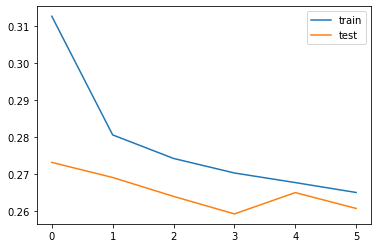

In [24]:
plt.plot(lstm_history.history["loss"], label="train")
plt.plot(lstm_history.history["val_loss"], label="test")
plt.legend()
plt.show()